# Preprocessing file names

In [2]:
# Preprocessing file names for the dataset
import os

def rename_files_in_folder(folder_path, GEN):
    files = os.listdir(folder_path)
    files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]
    files.sort()
    
    for index, file_name in enumerate(files):
        extension = os.path.splitext(file_name)[1]
        if GEN:
            new_file_name = f"gen{index + 1}{extension}"
        else:
            new_file_name = f"real{index + 1}{extension}"
        
        old_file_path = os.path.join(folder_path, file_name)
        new_file_path = os.path.join(folder_path, new_file_name)
        
        os.rename(old_file_path, new_file_path)

generated_images = "E:\\CS 512 Project\\Proj\\data_image_classification\\generated_images"
real_images = "E:\\CS 512 Project\\Proj\\data_image_classification\\real_images"

In [3]:
rename_files_in_folder(generated_images, True)
rename_files_in_folder(real_images, False)

# Basic model trial

In [1]:
!pip install tensorflow matplotlib
!pip install scipy
!pip install -U scikit-learn

In [2]:
import numpy as np

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to your data directories
base_dir = 'E:\\CS 512 Project\\Proj\\data_image_classification'
train_dir_generated = os.path.join(base_dir, 'generated_images')
train_dir_real = os.path.join(base_dir, 'real_images')

# Define paths to your data directories
base_dir = 'E:/CS 512 Project/Proj/data_image_classification'
train_dir_generated = os.path.join(base_dir, 'generated_images')
train_dir_real = os.path.join(base_dir, 'real_images')

# Create ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # use 20% of the images as validation data
)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,
    class_mode='binary',  # binary labels
    subset='training'  # specify this is training data
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # specify this is validation data
)



Found 603 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'generated_images': 0, 'real_images': 1}

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


c:\Users\Manan\anaconda3\envs\proj\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Corrected to be an integer
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,  # Corrected to be an integer
    # class_weight=class_weights_dict  # Ensure class_weights_dict is defined as shown earlier
)


Epoch 1/20


c:\Users\Manan\anaconda3\envs\proj\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 19/100 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.7239 - loss: 0.7427

c:\Users\Manan\anaconda3\envs\proj\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7528 - loss: 0.6143 - val_accuracy: 0.7533 - val_loss: 0.5354
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8244 - loss: 0.4039 - val_accuracy: 0.7533 - val_loss: 0.5221
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8286 - loss: 0.3843 - val_accuracy: 0.7800 - val_loss: 0.5888
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8418 - loss: 0.3616 - val_accuracy: 0.7667 - val_loss: 0.5736
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8681 - loss: 0.3373 - val_accuracy: 0.7800 - val_loss: 0.5771
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8929 - loss: 0.2867 - val_accuracy: 0.7800 - val_loss: 0.6656
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8713 - loss: 0.3297 - val_accuracy: 0.7867 - val_loss: 0.4862
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9021 - loss: 0.2644 - val_accuracy: 0.813

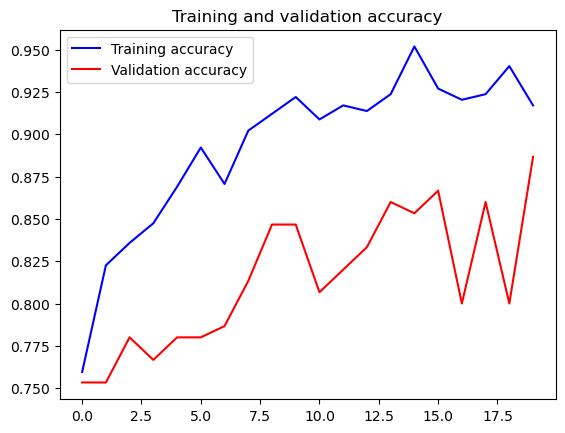

In [9]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
